# Project prototype in pytorch

## Import phase

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt

In [2]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Read CSV file

In [3]:
columns = ['center','left','right','steering','throttle','reverse', 'speed']
data = pd.read_csv('./driving_log.csv', names = columns, sep=';')

In [4]:
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/IMG/center_2020_07_14_14_18_36_008.jpg,/IMG/left_2020_07_14_14_18_36_008.jpg,/IMG/right_2020_07_14_14_18_36_008.jpg,-0.158824,0.000000,0,8.075665
1,/IMG/center_2020_07_14_14_18_36_090.jpg,/IMG/left_2020_07_14_14_18_36_090.jpg,/IMG/right_2020_07_14_14_18_36_090.jpg,-0.170588,0.000000,0,7.992766
2,/IMG/center_2020_07_14_14_18_36_168.jpg,/IMG/left_2020_07_14_14_18_36_168.jpg,/IMG/right_2020_07_14_14_18_36_168.jpg,-0.170588,0.000000,0,7.944249
3,/IMG/center_2020_07_14_14_18_36_247.jpg,/IMG/left_2020_07_14_14_18_36_247.jpg,/IMG/right_2020_07_14_14_18_36_247.jpg,-0.170588,0.263050,0,8.021999
4,/IMG/center_2020_07_14_14_18_36_343.jpg,/IMG/left_2020_07_14_14_18_36_343.jpg,/IMG/right_2020_07_14_14_18_36_343.jpg,-0.170588,0.241389,0,8.324794


In [5]:
data.nunique()

center      2489
left        2489
right       2489
steering     138
throttle     576
reverse        1
speed       1195
dtype: int64

In [6]:
data.agg(['min', 'max'])

,center,left,right,steering,throttle,reverse,speed
min,/IMG/center_2020_07_14_14_18_36_008.jpg,/IMG/left_2020_07_14_14_18_36_008.jpg,/IMG/right_2020_07_14_14_18_36_008.jpg,-0.976471,0.0,0,0.001131
max,/IMG/center_2020_07_14_14_33_42_992.jpg,/IMG/left_2020_07_14_14_33_42_992.jpg,/IMG/right_2020_07_14_14_33_42_992.jpg,0.841176,1.0,0,30.550280


In [7]:
data_cropped = data.drop(columns=['reverse', 'left', 'right', 'speed'])
data.head()

,center,left,right,steering,throttle,reverse,speed
0,/IMG/center_2020_07_14_14_18_36_008.jpg,/IMG/left_2020_07_14_14_18_36_008.jpg,/IMG/right_2020_07_14_14_18_36_008.jpg,-0.158824,0.000000,0,8.075665
1,/IMG/center_2020_07_14_14_18_36_090.jpg,/IMG/left_2020_07_14_14_18_36_090.jpg,/IMG/right_2020_07_14_14_18_36_090.jpg,-0.170588,0.000000,0,7.992766
2,/IMG/center_2020_07_14_14_18_36_168.jpg,/IMG/left_2020_07_14_14_18_36_168.jpg,/IMG/right_2020_07_14_14_18_36_168.jpg,-0.170588,0.000000,0,7.944249
3,/IMG/center_2020_07_14_14_18_36_247.jpg,/IMG/left_2020_07_14_14_18_36_247.jpg,/IMG/right_2020_07_14_14_18_36_247.jpg,-0.170588,0.263050,0,8.021999
4,/IMG/center_2020_07_14_14_18_36_343.jpg,/IMG/left_2020_07_14_14_18_36_343.jpg,/IMG/right_2020_07_14_14_18_36_343.jpg,-0.170588,0.241389,0,8.324794


In [8]:
data.tail()

,center,left,right,steering,throttle,reverse,speed
2484,/IMG/center_2020_07_14_14_33_42_674.jpg,/IMG/left_2020_07_14_14_33_42_674.jpg,/IMG/right_2020_07_14_14_33_42_674.jpg,-0.182353,0.0,0,10.007120
2485,/IMG/center_2020_07_14_14_33_42_750.jpg,/IMG/left_2020_07_14_14_33_42_750.jpg,/IMG/right_2020_07_14_14_33_42_750.jpg,-0.147059,0.0,0,9.928753
2486,/IMG/center_2020_07_14_14_33_42_834.jpg,/IMG/left_2020_07_14_14_33_42_834.jpg,/IMG/right_2020_07_14_14_33_42_834.jpg,-0.088235,0.0,0,9.850438
2487,/IMG/center_2020_07_14_14_33_42_917.jpg,/IMG/left_2020_07_14_14_33_42_917.jpg,/IMG/right_2020_07_14_14_33_42_917.jpg,-0.082353,0.0,0,9.772010
2488,/IMG/center_2020_07_14_14_33_42_992.jpg,/IMG/left_2020_07_14_14_33_42_992.jpg,/IMG/right_2020_07_14_14_33_42_992.jpg,-0.064706,0.0,0,9.693918


In [9]:
data_cropped.head()

,center,steering,throttle
0,/IMG/center_2020_07_14_14_18_36_008.jpg,-0.158824,0.000000
1,/IMG/center_2020_07_14_14_18_36_090.jpg,-0.170588,0.000000
2,/IMG/center_2020_07_14_14_18_36_168.jpg,-0.170588,0.000000
3,/IMG/center_2020_07_14_14_18_36_247.jpg,-0.170588,0.263050
4,/IMG/center_2020_07_14_14_18_36_343.jpg,-0.170588,0.241389


# Dataset Split

utility cells to split the log file in training and testing sets

In [10]:
#data[:2400].to_csv("./driving_log_train.csv", sep=';', index=False, header=False)
#data[2400:].to_csv("./driving_log_test.csv", sep=';', index=False, header=False)

## Dataset and Dataloader

In [11]:
class UdacityDataset(Dataset):   
    def __init__(self, csv_file, root_dir, transform=None, act_transform=None, split=None):
        columns = ['center','left','right','steering','throttle','reverse', 'speed']
        if split:
            self.annotations = pd.read_csv(f'./driving_log_{split}.csv', sep=';', names = columns)
        else:
            self.annotations = pd.read_csv('./driving_log.csv', sep=';', names = columns)
        self.root_dir = root_dir
        self.transform = transform
        self.act_transform = act_transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.root_dir + self.annotations.iloc[idx]['center']
        steer = self.annotations.iloc[idx]['steering'].astype(np.float32)
        throttle = self.annotations.iloc[idx]['throttle'].astype(np.float32)
        image = io.imread(img_name)
        if self.transform:
            image = self.transform(image)
        action = np.array([steer, throttle])
        if self.act_transform:
            action = self.act_transform(action)
            
        return image, action

In [12]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
])

action_transform = transforms.Compose([
    transforms.ToTensor(),
])

## Autoencoder model

The autoencoder has been trained in the related notebook and will be loaded and used here

In [13]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(8*32*32, 100)
        )
        self.bridge = nn.Sequential(nn.Linear(100, 8*32*32))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )
         
    def forward(self, x):
        x = self.encoder(x)
        x = self.bridge(x)
        x = x.reshape(x.shape[0], -1, 32, 32)
        x = self.decoder(x)
        return x


In [14]:
cnn = Autoencoder()
cnn.load_state_dict(torch.load('./Autoencoder.pth', weights_only=True))
cnn.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=8192, out_features=100, bias=True)
  )
  (bridge): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 3, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)

## Behavior Cloning model

In [15]:
class PolicyNet(nn.Module):
    def __init__(self):
        super(PolicyNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(100, 300),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.head1 = nn.Sequential(
            nn.Linear(50, 1),
            nn.Tanh()
        )
        self.head2 = nn.Sequential(
            nn.Linear(50, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.net(x)
        steer = self.head1(x)
        throttle = self.head2(x)
        return torch.cat((steer, throttle))

In [16]:
policyNet = PolicyNet()

In [17]:
train_set = UdacityDataset('./driving_log.csv','./', transform = img_transform, split="train")
test_set = UdacityDataset('./driving_log.csv','./', transform = img_transform, split="test")

In [18]:
train_loader = DataLoader(dataset=train_set)
test_loader = DataLoader(dataset=test_set)

In [19]:
policyNet.to(device)

PolicyNet(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=50, bias=True)
    (7): ReLU()
  )
  (head1): Sequential(
    (0): Linear(in_features=50, out_features=1, bias=True)
    (1): Tanh()
  )
  (head2): Sequential(
    (0): Linear(in_features=50, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [20]:
criterion = nn.MSELoss()
optimizer = optim.SGD(policyNet.parameters(), lr=0.001)

In [21]:
num_epochs = 50
losses = []
counter = 0
for img, act in train_loader:
    img.to(device)
    img.unsqueeze(0)
    act = act.transpose(0,1)
    with torch.no_grad():
        representation = cnn.encoder(img)
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        output = policyNet(representation)
        loss = criterion(output, act)
        loss.backward()
        optimizer.step()
        if epoch == (num_epochs-1):
            losses.append(loss.item())
        counter = counter + 1
        if (counter % (int((len(train_set) * 0.1)) * num_epochs)) == 0:
            print(f'{counter // (int((len(train_set) * 0.1)) * num_epochs)}0% completed')

10% completed
20% completed
30% completed
40% completed
50% completed
60% completed
70% completed
80% completed
90% completed
100% completed


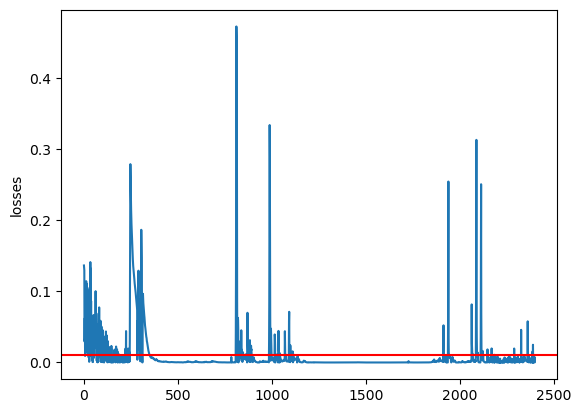

In [22]:
plt.plot(losses)
plt.axhline(y=np.mean(losses), color='red')
plt.ylabel('losses')
plt.show()

In [23]:
policyNet.eval()

PolicyNet(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=300, bias=True)
    (1): ReLU()
    (2): Linear(in_features=300, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=50, bias=True)
    (7): ReLU()
  )
  (head1): Sequential(
    (0): Linear(in_features=50, out_features=1, bias=True)
    (1): Tanh()
  )
  (head2): Sequential(
    (0): Linear(in_features=50, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

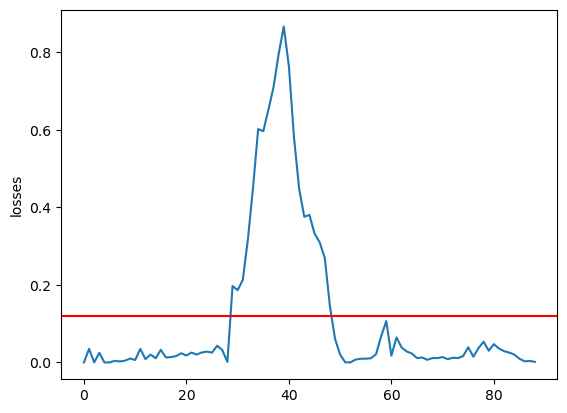

In [25]:
losses = []
for img, act in test_loader:
    img.to(device)
    img.unsqueeze(0)
    act = act.transpose(0,1)
    with torch.no_grad():
        representation = cnn.encoder(img)
        output=policyNet(representation)
        loss = criterion(output, act)
        losses.append(loss)

plt.plot(losses)
plt.axhline(y=np.mean(losses), color='red')
plt.ylabel('losses')
plt.show()